## Predictive power of dimensionless features 
The transport of nanomaterials is difficult to predict. Using our developed machine learning tools, let's investigate if prediction is more powerful when we seperate the parameters than if we arrange the parameters as dimensionless ratios. 


### Let's import a bunch of packages

In [170]:
%matplotlib inline
import multiprocessing
import numpy as np
multiprocessing.cpu_count()
from helperFunctions import *
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn import cross_validation
from sklearn.feature_selection import RFECV
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import StratifiedShuffleSplit
import matplotlib
import matplotlib.pyplot as plt
from biokit.viz import corrplot
matplotlib.rcParams['figure.dpi'] = 120
matplotlib.rcParams['figure.figsize'] = (8,6)

### Let's import a database! 
#### Notice that the List of features includes:
*  ObsRPShape
*  Poros
*  Darcy
*  ConcIn
*  PvIn
*  pH
*  IonStr
*  SaltType
*  ColumnLWRatio
*  PartDensity 
*  PartIEP * Bullet pHIEPDist 
*  PartZeta 
*  CollecZeta
*  PartDiam
*  CollecDiam
*  PartCollSizeRatio 
*  Coating 
*  ConcHA 
*  TypeNOM 
*  Hamaker
*  Dispersivity
*  NanoSize
*  mbEffluent
*  mbRetained
*  mbEffluent_norm
*  mbRetained_norm

In [171]:
# locate the csv database
path = './transportData.csv'

# Import the csv as a dataframe.
data = pd.DataFrame.from_csv(path, header=0, sep=',', 
                             index_col=0, parse_dates=True, encoding=None,
                               tupleize_cols=False, infer_datetime_format=False)

### Not all the features are sufficient to support ML (our database is small anyway), so let's drop some features. This consistutes the first drop round.

In [172]:
featuresToDrop = ['Hamaker','Dispersivity','NanoSize','pHIEPDist',
                  'PartCollSizeRatio','ColumnLWRatio',
                  'mbEffluent', 'mbRetained','mbEffluent_norm']
data = data.drop(featuresToDrop,1)

### Let's put the data we can into our dimensionless quantities. 

In [173]:
data['tempKelvin'] = 298.15 # the temperature is always assumed to be 25 degrees.
data['relPermValue'] = data.apply(relPermittivity,axis=1) # Calculate the rel permittivity 
data['debyeLength'] = data.apply(debyeLength,axis=1) # Calculate the debye length
data['pecletNumber'] = data.apply(pecletNumber,axis=1)
data['aspectRatio'] = data.PartDiam/data.CollecDiam
data['zetaRatio'] = data.PartZeta/data.CollecZeta
data['pHIepRatio'] = data.pH/data.PartIEP

### Factorize the remaining training data fields to turn categories into numbers. 

In [174]:
data['Coating'] = data['Coating'].factorize()[0]
data['SaltType'] = data['Coating'].factorize()[0]
data['NMId'] = data['NMId'].factorize()[0]
data['TypeNOM'] = data['TypeNOM'].factorize()[0]

### Do not include any experiments which have null values.

In [175]:
data = data.dropna()

### Set the target data fields. In this case, the 'ObsRPShape' and the 'mbRetained_norm' (i.e., retained fration, RF).

In [176]:
targetDataRPShape = data['ObsRPShape'].factorize()[0] # convert text to numeric values
targetDataRPShapeUniqueList = list(set(data['ObsRPShape'].unique()))
targetDataRF = data.mbRetained_norm

### Drop the fields that are subordinate to the calculated fields (i.e., the ones wrapped up in the dimensionless numbers (e.g., SaltType and pH are in debyelength).

In [177]:
data = data.drop(['ObsRPShape', # target value (to be predicted)
                  'mbRetained_norm', # target value (to be predicted)
                  'Darcy', # included in peclet number
                  'ObsRPShape', # target value (to be predicted)
                  'relPermValue', # perfectly correlated wiht material and include in Debye
                  'tempKelvin', # assumed to be the same for each experiment (also in Debye)
                  'PartZeta', # included in dimensionless ratio of zetas
                  'PartIEP', # included in dimensionless ratio of pH to IEP
                  'PartDiam', # included in dimensionless aspect ratio
                  'CollecDiam', # included in dimensionless aspect ratio
                  'CollecZeta',# included in dimensionless aspect ratio
                  'IonStr', # included in Debye Length
                  'SaltType',# included in Debye Length
                  'pH'# included in dimensionless ratio of pH to IEP
                 ],1)

print list(data) # print out the remaining data field headers

['NMId', 'Poros', 'ConcIn', 'PvIn', 'PartDensity', 'Coating', 'ConcHA', 'TypeNOM', 'debyeLength', 'pecletNumber', 'aspectRatio', 'zetaRatio', 'pHIepRatio']


### Let's check to see how correlated our variables are!

Computing correlation


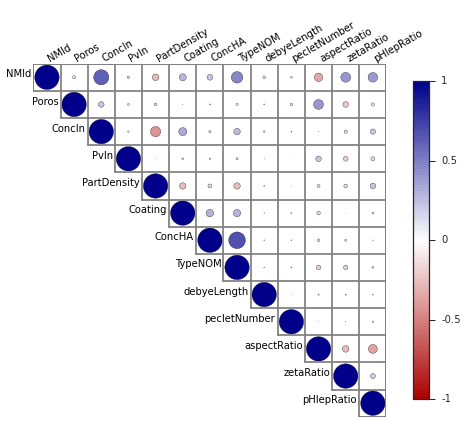

In [178]:
# Make sure to install biokit dependencies with requirements.txt
# https://pypi.python.org/pypi/biokit/0.0.5

c = corrplot.Corrplot(data)
c.plot(upper='circle',fontsize = 10)

### Now that we've verified that our variables are not heavily correlated, we can develop an empirical prediction model that uses the nano transport experimental conditions to predict the outcomes. 


#### Assign the remaining data to the training data set. Then, Store the training data and target data as a matrices for import into ML.

In [179]:
trainData = data
trainDataMatrix = trainData.as_matrix() # all numbers, no headers
tarDataRPShapeMatrix = targetDataRPShape
tarDataRFMatrix =  targetDataRF.as_matrix() # all numbers, no headers

# Get a list of the trainingData features remaining. This is used later for plotting etc.
trainingDataNames =  list(trainData)

#### Engage the RFECV classifier function to reduce the model overfitting and investigate the influence of the parameters on the prediction score. 

In [141]:
# 1000 trees
# run the model 10 times - this will take a while
# maximum tree depth is 4 - this is a bit shallow, but less depth can speed/improve prediction 
stratShuffleSplitRFECVRandomForestClassification (nEstimators= 1000,
                                                  iterator1=10,
                                                  minSamplesSplit=2,
                                                  maxFeatures=None,
                                                  maxDepth=4,
                                                  nFolds=5,
                                                  targetDataMatrix = tarDataRPShapeMatrix,
                                                  trainingData = trainData,
                                                  trainingDataMatrix = trainDataMatrix,
                                                  SEED = 5)

iteration no:  1
[0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0]
[0 0 0 1 0 0 0 3 4 4 0 0 3 3 2 4 0 0]
iteration no:  2
[3 0 0 0 0 0 0 3 1 0 3 0 3 0 0 3 0 3]
[0 4 0 0 4 2 0 0 1 4 3 0 0 0 0 3 0 3]
iteration no:  3
[0 0 3 0 1 0 0 0 0 3 0 0 1 0 0 0 0 0]
[0 0 3 4 3 0 0 0 0 3 0 4 1 2 0 0 0 4]
iteration no:  4
[0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 1]
[4 4 0 0 0 4 0 0 0 3 2 3 3 0 0 0 0 1]
iteration no:  5
[0 0 0 0 1 0 0 0 0 0 0 3 1 0 0 0 0 0]
[0 4 3 0 1 0 0 0 2 4 0 3 3 0 0 0 0 4]
iteration no:  6
[3 0 0 0 0 0 3 0 0 0 0 0 3 0 3 1 0 0]
[3 4 0 0 4 0 0 0 0 0 3 2 0 4 0 1 0 3]
iteration no:  7
[3 0 1 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0]
[3 0 1 2 4 4 0 0 0 3 0 0 4 3 0 0 0 0]
iteration no:  8
[3 1 0 0 0 0 0 0 0 0 0 3 3 0 0 0 0 0]
[3 1 0 0 0 0 4 0 0 0 0 2 3 4 0 0 3 4]
iteration no:  9
[0 0 3 0 0 0 0 0 0 0 1 0 0 0 0 0 0 3]
[4 0 3 0 0 0 4 0 0 3 1 2 0 0 0 4 0 3]
iteration no:  10
[3 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
[2 3 0 0 1 3 0 0 0 3 0 0 0 4 0 4 4 0]
List of Important Features Identified by Recursive Selection Method:


### Let's plot the results - do they make sense?

/Users/future/PycharmProjects/rfecvNano
/Users/future/PycharmProjects/rfecvNano
0    0.559276
dtype: float64
0    0.633333
dtype: float64
0    0.441339
dtype: float64
          0
0 -0.437500
0 -0.645833
0 -0.166667
0 -0.458333
0 -0.354167
0 -1.020833
0 -0.270833
0 -0.208333
0 -0.270833
0 -0.479167
Median F1 Score and STD 0    0.565527
dtype: float64 0    0.074174
dtype: float64
          0         1         2         3         4         5         6  \
0  0.666026  0.687454  0.668058  0.682142  0.682142  0.695736  0.695736   
0  0.589864  0.575824  0.622007  0.656582  0.663478  0.643634  0.650777   
0  0.622567  0.662944  0.685019  0.684574  0.684574  0.672074  0.679018   
0  0.662146  0.670535  0.649842  0.670778  0.656092  0.656092  0.642299   
0  0.637544  0.639934  0.647768  0.654422  0.681854  0.682100  0.674957   
0  0.670867  0.663926  0.651225  0.650533  0.657676  0.677521  0.656783   
0  0.608972  0.629553  0.656003  0.663593  0.670490  0.676942  0.656652   
0  0.631537  0.6058

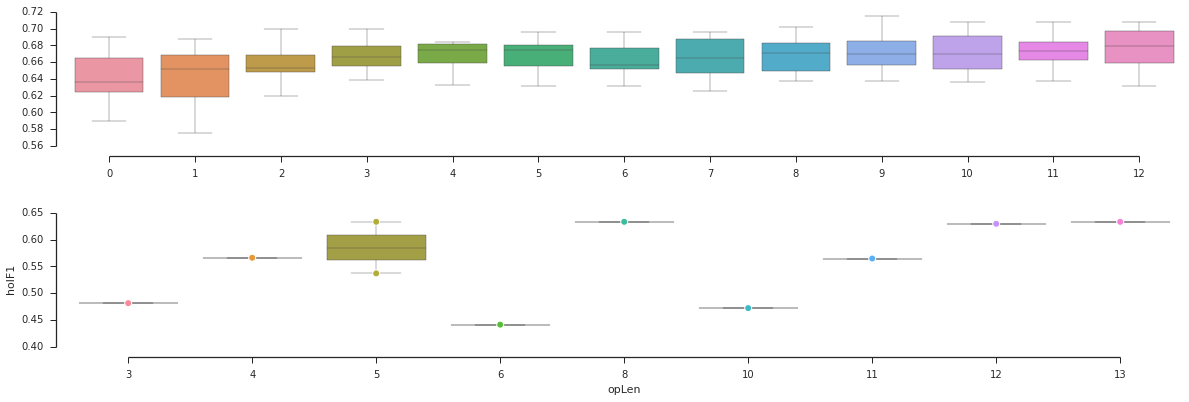

         feature  observation %
0           NMId             30
1          Poros            100
2         ConcIn             50
3           PvIn             70
4    PartDensity             70
5        Coating             50
6         ConcHA             40
7        TypeNOM             10
8    debyeLength             20
9   pecletNumber            100
10   aspectRatio             40
11     zetaRatio             90
12    pHIepRatio            100


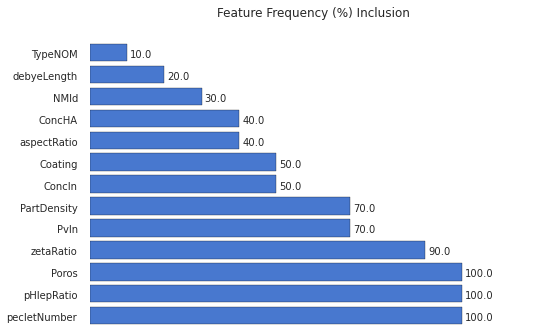

In [186]:
# Output file summary
fileName1 = './outputFiles/f1_score_all.csv'
fileName2 = './outputFiles/class_IFIRS.csv'
fileName3 = './outputFiles/class_optimum_length.csv'
fileName4 = './outputFiles/class_sel_feature_importances.csv'
fileName5 = './outputFiles/class_rfecv_grid_scores.csv'
fileName6 = './outputFiles/class_Rsq_score_all.csv'

iterator1 = 10 # This is the number of model iterations 

# This is the packaged call script to plot things! 
classificationSixFilePlot(fileName1,
                              fileName2,
                              fileName3,
                              fileName4,
                              fileName5,
                              fileName6, iterator1, trainingData)